# RAG System (T-Bank)




In [1]:
import json
import os
import re
import gc
from typing import Any
from google.colab import userdata

import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import Dataset

# Transformers
from transformers import (
    pipeline,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoModelForCausalLM
)
from transformers.pipelines.pt_utils import KeyDataset
from sentence_transformers import CrossEncoder

#LangChain
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFaceEndpoint, ChatHuggingFace
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import DataFrameLoader
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever

#Ragas
from ragas import evaluate
from ragas.metrics import (
    context_precision,
    context_recall,
    answer_relevancy,
    faithfulness
)
from ragas.run_config import RunConfig
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper

/usr/local/lib/python3.12/dist-packages/google/colab/_import_hooks/_hook_injector.py:55: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  loader.exec_module(module)
/tmp/ipython-input-3309876754.py:35: DeprecationWarning: Importing context_precision from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import context_precision
  from ragas.metrics import (
/tmp/ipython-input-3309876754.py:35: DeprecationWarning: Importing context_recall from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import context_recall
  from ragas.metrics 

Загрузка локальной модели


In [2]:
# Модель
model_id = "Qwen/Qwen2.5-7B-Instruct"

# Настройка квантования
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True

)

# Токенизатор
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

# Загрузка модели
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    dtype=torch.float16
)

# Пайплайн для коротких ответов: да/нет
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=10,
    temperature=0.1,
    top_p=0.9

)

print("Эмбединнги")
embed_model = "deepvk/USER-bge-m3"

embeddings = HuggingFaceEmbeddings(
    model_name=embed_model,
    model_kwargs={'device': "cuda" if torch.cuda.is_available() else "cpu"},
    encode_kwargs={'normalize_embeddings': True}
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

Device set to use cuda:0


Эмбединнги


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/697 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Обработка


In [4]:
# Загрузка данных
FILE_PATH = '/content/sudact_dataset0_500.json'

def load_data(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        print( "Файл не найден")
        return pd.DataFrame()

    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return pd.DataFrame(data)

df = load_data(FILE_PATH)

In [5]:
class Preprocessor:
  """Класс для очистки юридических документов и фильтрации через классический фильтр и LLM"""

  def __init__(self, df, pipe, tokenizer, BATCH_SIZE: int = 16):
    self.BATCH_SIZE = BATCH_SIZE
    self.df = df.copy()
    self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    self.pipe=pipe
    self.tokenizer=tokenizer
    tqdm.pandas()

  def clean_text(self, text: str) -> str:
    """Базовая очистка лишних пробелов и переносов"""
    text = text.replace('\t', ' ')
    text = re.sub(r'\n+', '\n', text)
    text = re.sub(r' +', ' ', text)
    return text.strip()

  def basic_filter(self, text: str) -> bool:
    """Отсекаю уголовные дела по ключевым словам"""
    criminal_pattern = r'приговор|постановление\s+о\s+прекращении\s+уголовного'
    if re.search(criminal_pattern, text, re.IGNORECASE):
      return False
    return True

  def create_prompt(self, text: str) -> str:
    """Создание промпта"""
    header = text[:4000]
    message = [
        {"role": "system", "content": "Ты — юридический эксперт. Анализируй стороны в судебном деле. Отвечай только одним словом: ДА или НЕТ."},
        {"role": "user", "content": f"Является ли 'Т-Банк' (Тинькофф) АКТИВНЫМ участником (истец, ответчик, третье лицо, заявитель)? Если банк просто упомянут как платежный агент или банк получателя — отвечай НЕТ.\n\nТекст:\n{header}"}
    ]
    prompt = self.tokenizer.apply_chat_template(
        message,
        tokenize=False,
        add_generation_prompt=True
    )
    return prompt

  def preprocess(self) -> pd.DataFrame:
    """Основной цикл обработки"""
    print("Очистка текста")
    self.df['clean_content'] = self.df['content'].progress_apply(self.clean_text)
    print("Очистка заголовков")
    self.df['clean_title'] = self.df['title'].progress_apply(self.clean_text)

    print("Классический фильр")
    mask_classic = self.df['clean_title'].progress_apply(self.basic_filter)
    current_df = self.df[mask_classic].copy()

    print(f"Подготовка промптов для {len(current_df)} документов")
    prompts = [self.create_prompt(text) for text in tqdm(current_df['clean_content'])]
    dataset = Dataset.from_dict({'prompt': prompts})

    print(f"Запуск инференса: (Batch size: {self.BATCH_SIZE})")
    nn_answers = []

    for output in tqdm(self.pipe(
        KeyDataset(dataset, "prompt"),
        max_new_tokens=8,
        pad_token_id=self.tokenizer.eos_token_id,
        return_full_text=False,
        batch_size=self.BATCH_SIZE
    ), total=len(prompts), desc="Обработка нейросетью"):
      #Берем ответ и проверяем наличие "да"
      answer = 'да' in output[0]['generated_text'].strip().lower()
      nn_answers.append(answer)

    current_df['is_legal'] = nn_answers
    final_df = current_df[current_df['is_legal']].copy()

    print(f"Отобрано было {len(final_df)} из {len(self.df)}")
    return final_df




In [6]:
# Инициализация и запуск предобработки
transform = Preprocessor(df, pipe, tokenizer)
final_data = transform.preprocess()

# Сохранение результата
final_data.to_csv("SudAct_t_bank_500.csv", index=False, encoding='utf-8-sig')


Очистка текста


100%|██████████| 500/500 [00:02<00:00, 206.22it/s]


Очистка заголовков


100%|██████████| 500/500 [00:00<00:00, 86541.16it/s]


Классический фильр


100%|██████████| 500/500 [00:00<00:00, 258620.30it/s]


Подготовка промптов для 308 документов


100%|██████████| 308/308 [00:00<00:00, 6262.95it/s]


Запуск инференса: (Batch size: 16)


Обработка нейросетью: 100%|██████████| 308/308 [08:30<00:00,  1.66s/it]


Отобрано было 177 из 500


In [8]:
# Загрузка уже отфильтрованных данных
# Позволяет не перезапускать классификацию
DATA_PATH = "/content/SudAct_t_bank_500.csv"

def load_data_csv(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        print( "Файл не найден")
        return pd.DataFrame()

    return pd.read_csv(path)

final_data = load_data_csv(DATA_PATH)

Подсчет токенов
Минимальная длина: 812
Средняя длина: 5310
Медиана: 4836
Максимум: 16074


/tmp/ipython-input-993509227.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


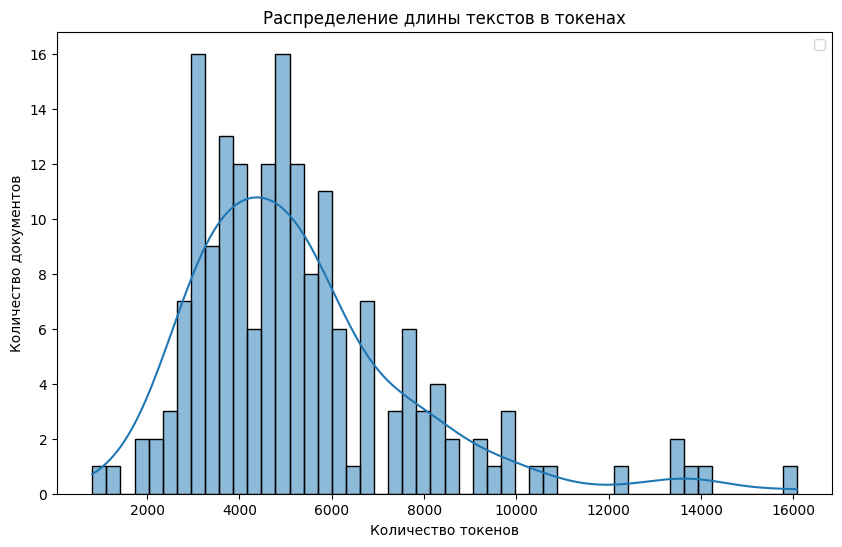

In [9]:
# Анализ длины документов для выбора парметрова чанкинга
def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

print("Подсчет токенов")
token_counts = [count_tokens(text) for text in final_data['clean_content']]

# Вывод статистики
print(f"Минимальная длина: {min(token_counts)}")
print(f"Средняя длина: {int(sum(token_counts)/len(token_counts))}")
print(f"Медиана: {sorted(token_counts)[len(token_counts)//2]}")
print(f"Максимум: {max(token_counts)}")

# Визуал
plt.figure(figsize=(10, 6))
sns.histplot(token_counts, bins=50, kde=True)
plt.title('Распределение длины текстов в токенах')
plt.xlabel('Количество токенов')
plt.ylabel('Количество документов')
plt.legend()
plt.show()

In [11]:
# Загрузка документов в формат Лангчеин
print("Загрузка данных")
loader = DataFrameLoader(final_data, page_content_column="clean_content")
documents = loader.load()

# Разбиение на чанки
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=300,
    separators=["\n", ". ", " "]
)
splits = text_splitter.split_documents(documents)
print(f"Документов: {len(documents)}")
print(f"Чанков создано: {len(splits)}")


Загрузка данных
Документов: 177
Чанков создано: 4037


Иницилизация поиска и генерации



In [13]:
# Векторная БД
print("Создаем векторную базу данных")
vector_db = FAISS.from_documents(documents=splits, embedding=embeddings)
faiss_retriever = vector_db.as_retriever(search_kwargs={"k": 10})

# ВМ25
print("BM25 Ретривер")
bm25_retriever = BM25Retriever.from_documents(splits)
bm25_retriever.k = 10

# Создаю ансамбль
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever],
    weights=[0.5, 0.5]
)

# Реранкер
print("Загрузка реранкера")
reranker_model = CrossEncoder(
    'BAAI/bge-reranker-v2-m3',
    device='cuda' if torch.cuda.is_available() else 'cpu',
    max_length=1024
)

def reranked_context(query: str, retriever: Any, reranker: Any, top_n: int=7):
  """Переранжирование документов для точности"""
  # Первичный поиск
  initial_docs = retriever.invoke(query)

  # Оценка релевантности
  pairs = [[query, doc.page_content] for doc in initial_docs]
  scores = reranker.predict(pairs)

  # Сортировка по скору
  score_and_docs = list(zip(scores, initial_docs))
  score_and_docs = sorted(score_and_docs, key=lambda x: x[0], reverse=True)
  top_docs = score_and_docs[:top_n]

  # Сборка контекста для ЛЛМ
  final_context = ""
  source_info = []

  # Список текста для Рагас
  ragas_contexts = []

  for score, doc in top_docs:
    title = doc.metadata['title']
    url = doc.metadata['url']

    final_context += f"\n--- НАЧАЛО ДОКУМЕНТА: {title} ---\n"
    final_context += doc.page_content
    final_context += f"\n--- КОНЕЦ ДОКУМЕНТА ---\n"

    source_info.append(f"Title: {title}\nURL: {url}\nScore: {score:.4f}")

    ragas_contexts.append(doc.page_content)

  return final_context, source_info, ragas_contexts

def generate_answer_rag(query: str, retriever: Any, reranker: Any, pipe: Any) -> tuple:
  """Генерация ответа на основе предоставленного контекста"""
  context, source, context_list = reranked_context(query, retriever, reranker)

  messages = [
      {"role": "system", "content": "Ты - юридиеский эксперт. Отвечай на вопросы только на основе предоставленного контекста."},
      {"role": "user", "content": f"Контекст:\n{context}\n\n Вопрос:\n {query}"}
  ]

  prompt = pipe.tokenizer.apply_chat_template(
      messages,
      tokenize=False,
      add_generation_prompt=True
  )

  # Очищаем кэш
  torch.cuda.empty_cache()
  gc.collect()

  # Генерируем без расчета градиентов
  with torch.no_grad():
      output = pipe(
      prompt,
      max_new_tokens=512,
      return_full_text=False
      )



  answer = output[0]['generated_text'].strip()
  return answer, source, context_list


Создаем векторную базу данных
BM25 Ретривер
Загрузка реранкера


config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [14]:
# Очистка мусора
gc.collect()
torch.cuda.empty_cache()

# Тестовый запрос
query = "В каких случаях Т-Банк выступал истцом?"
answer, sources, context = generate_answer_rag(query, ensemble_retriever, reranker_model, pipe)

print("КОНТЕКСТ:\n", context)
print("ОТВЕТ:\n", answer)
print("\nИСТОЧНИКИ:\n", "\n".join(sources))

КОНТЕКСТ:
 ['Истец Акционерное общество « Т Банк » (далее – АО «ТБанк») обратилось в суд с иском к ФИО1 о взыскании задолженности по договору кредитному договору.\nТребования мотивированы тем, что ДД.ММ.ГГ между АО «Тинькофф Банк» (далее - «Банк») и ФИО1 (далее - «Должник») был заключен кредитный договор №.\nВ соответствии с Договором Должник взял на себя обязательства уплачивать проценты за пользование кредитом, предусмотренные комиссии и платы, а также обязанность вернуть Банку заёмные денежные средства.', 'Истцы:\nАкционерное общество "ТБанк" (подробнее)\nОтветчики:\nИнформация скрыта (подробнее)\nНаследственное имущество Мазитова Ришата Камилевича (подробнее)\nСудьи дела:\nШакиров Рустам Гильмуллович (судья) (подробнее)\nПоследние документы по делу:\nРешение от 1 июля 2025 г. по делу № 2-206/2025\nРешение от 9 марта 2025 г. по делу № 2-206/2025\nРешение от 13 февраля 2025 г. по делу № 2-206/2025\nПоказать все документы по этому делу\nСудебная практика по:\nПо кредитам, по кредитным

Метрики


In [ ]:
# Данные для теста
test_questions = [
    "Какую итоговую сумму задолженности суд взыскал с Росимущества по делу № 2-1730/2024 и почему она меньше заявленной истцом?",
    "Какую общую сумму (включая основной долг, моральный вред и штраф) суд взыскал с ООО «Эдэкс» в пользу ФИО1 по делу № 2-823/2025?",
    "Признал ли суд незаконным постановление о взыскании исполнительского сбора с ФИО1 по делу № 2а-1406/2025 и какая основная причина такого решения?",
    "Какую итоговую сумму (основной долг + моральный вред + штраф) суд взыскал с ООО «ЭдЭкс» в пользу Соболевского по делу № 2-782/2025 и как учитывались ранее выплаченные ответчиком 15 760 рублей?"
]

ground_truths = [
    "Суд взыскал 1285 рублей 16 копеек. Сумма ограничена стоимостью наследственного имущества (выморочного имущества), найденного на счетах умершего ФИО1.",
    "Суд взыскал с ООО «Эдэкс» в пользу ФИО1 общую сумму 165 829,59 рублей. Эта сумма складывается из: основного долга — 98 560 рублей, компенсации морального вреда — 5 000 рублей и штрафа — 62 269,59 рублей.",
    "Нет, суд отказал в удовлетворении иска и признал постановление законным. Причина: задолженность не была погашена в установленный для добровольного исполнения срок, а списание средств в АО 'Т-Банк' произошло уже после возбуждения исполнительного производства.",
    "Суд взыскал общую сумму 187 333,05 рублей (121 888,70 руб. долга, 3 000 руб. морального вреда и 62 444,35 руб. штрафа). Ранее выплаченные ответчиком 15 760 рублей (два платежа по 7 880 руб.) были вычтены из первоначальной суммы договора 137 648,70 руб. при расчете задолженности"
]

# Инференс
generated_answers = []
context_list = []

for query in tqdm(test_questions):
  answer, sources, top_chunks = generate_answer_rag(query, ensemble_retriever, reranker_model, pipe)
  generated_answers.append(answer)
  context_list.append(top_chunks)

# Сборка датасета
eval_data = {
    'question': test_questions,
    'answer': generated_answers,
    'contexts': context_list,
    'ground_truth': ground_truths
}


In [ ]:
# Сохраняем
df = pd.DataFrame(eval_data)
df.to_csv('eval_data_with_retriever.csv', index=False, encoding='utf-8-sig')

In [ ]:
# Считываем если есть eval_data чтобы не инференсить лишний раз
import ast
df = pd.read_csv('/content/eval_data_with_retriever.csv')
df['contexts'] = df['contexts'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
eval_data = df.to_dict(orient='list')

In [ ]:
# Подготовка датасета Рагас
ragas_dataset = Dataset.from_dict(eval_data)

# Буду использовать хаггин фейс апи для подсчета метрик рагас
os.environ["HUGGINGFACEHUB_API_TOKEN"] = userdata.get("HF_TOKEN")

# Перевожу в стандарт лангчеин
llm_lang = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen2.5-72B-Instruct",
    task='text-generation',
    max_new_tokens=4096,
    temperature=0.1,
    repetition_penalty=1.1
)

# Чат интерфейс
chat_with_llm = ChatHuggingFace(llm=llm_lang)

# финальная обертка для рагас
ragas_llm = LangchainLLMWrapper(chat_with_llm)

# Эмбеддинги
embedd_model = HuggingFaceEmbeddings(
    model_name="intfloat/multilingual-e5-small",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True}
)

# Обертка эмбеддингов для рагас
ragas_emb = LangchainEmbeddingsWrapper(embedd_model)

# Конфиг
custom_config = RunConfig(
    timeout=1200,
    max_retries=3,
    max_wait=600,
    max_workers=1,
    log_tenacity=True
)

# Метрики
metrics = [
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall
]

# Привязываю метрики к моделям
for metric in metrics:
  metric.llm = ragas_llm
  metric.embeddings = ragas_emb

#Запуск оценки
results = evaluate(
    dataset=ragas_dataset,
    metrics=metrics,
    llm=ragas_llm,
    embeddings=ragas_emb,
    run_config=custom_config
)

# Итоговые метрики
print("Итоговые метрики")
print(results)


In [ ]:
# Сохраняю
results_df = results.to_pandas()
results_df.to_csv('ragas_final_results.csv', index=False, encoding='utf-8-sig')